In [1]:
import json
from prettytable import PrettyTable
import json
import os
import random
import pandas as pd

# Read the jsonl file and convert it to a JSON list
def jsonl_to_json_list(jsonl_file_path):
    json_list = []
    with open(jsonl_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            json_obj = json.loads(line.strip())  # Parse each line as JSON
            json_list.append(json_obj)
    
    return json_list

# Save the JSON list to a file
def save_as_json(json_list, output_file_path):
    with open(output_file_path, 'w', encoding='utf-8') as outfile:
        json.dump(json_list, outfile, indent=4)

def save_as_jsonl(json_list, output_file_path):
    with open(output_file_path, 'w', encoding='utf-8') as outfile:
        for json_obj in json_list:
            json.dump(json_obj, outfile)
            outfile.write('\n')

def load_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

def load_jsonl(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = [json.loads(line.strip()) for line in file]
    return data

def deduplicate_data(data):
    seen = set()
    deduplicated_data = []
    for item in data:
        idx = item['realidx']
        if idx not in seen:
            deduplicated_data.append(item)
            seen.add(idx)
    return deduplicated_data

def calculate_accuracy(data):
    correct_predictions = 0
    total_predictions = len(data)
    for item in data:
        if 'predicted_answer' not in item:
            print(item['realidx'])
        if item['answer_idx'] == item['predicted_answer']:
            correct_predictions += 1
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    return accuracy

def calculate_cost_from_token_usage(data, model):
    total_cost = 0
    for item in data:
        if 'cost' in item:
            total_cost += item['cost']
        elif model == 'gpt-4o-mini':
            total_cost += item['token_usage']['prompt_tokens'] * 0.15 / 1000000 + item['token_usage']['completion_tokens'] * 0.6 / 1000000
        elif model == 'gpt-4o':
            total_cost += item['token_usage']['prompt_tokens'] * 2.5 / 1000000 + item['token_usage']['completion_tokens'] * 10 / 1000000
        elif model == 'o3-mini' or model == 'o1-mini':
            total_cost += item['token_usage']['prompt_tokens'] * 1.1 / 1000000 + item['token_usage']['completion_tokens'] * 4.4 / 1000000
        elif model == 'claude-3-5-sonnet':
            total_cost += item['token_usage']['prompt_tokens'] * 3.0 / 1000000 + item['token_usage']['completion_tokens'] * 15.0 / 1000000
        elif model == 'claude-3-5-haiku':
            total_cost += item['token_usage']['prompt_tokens'] * 0.8 / 1000000 + item['token_usage']['completion_tokens'] * 4.0 / 1000000
        elif model == 'QwQ-32B-Preview':
            total_cost += item['token_usage']['prompt_tokens'] * 1.2 / 1000000 + item['token_usage']['completion_tokens'] * 1.2 / 1000000
        elif model == 'DeepSeek-R1':
            total_cost += item['token_usage']['prompt_tokens'] * 7 / 1000000 + item['token_usage']['completion_tokens'] * 7 / 1000000
        elif model == 'DeepSeek-V3':
            total_cost += item['token_usage']['prompt_tokens'] * 1.25 / 1000000 + item['token_usage']['completion_tokens'] * 1.25 / 1000000
        elif model == 'Llama-3.3-70B-Instruct-Turbo':
            total_cost += item['token_usage']['prompt_tokens'] * 0.88 / 1000000 + item['token_usage']['completion_tokens'] * 0.88 / 1000000
    return total_cost / len(data)

def calculate_time_from_data(data):
    total_time = 0
    for item in data:
        total_time += item['time_elapsed']
    return total_time / len(data)

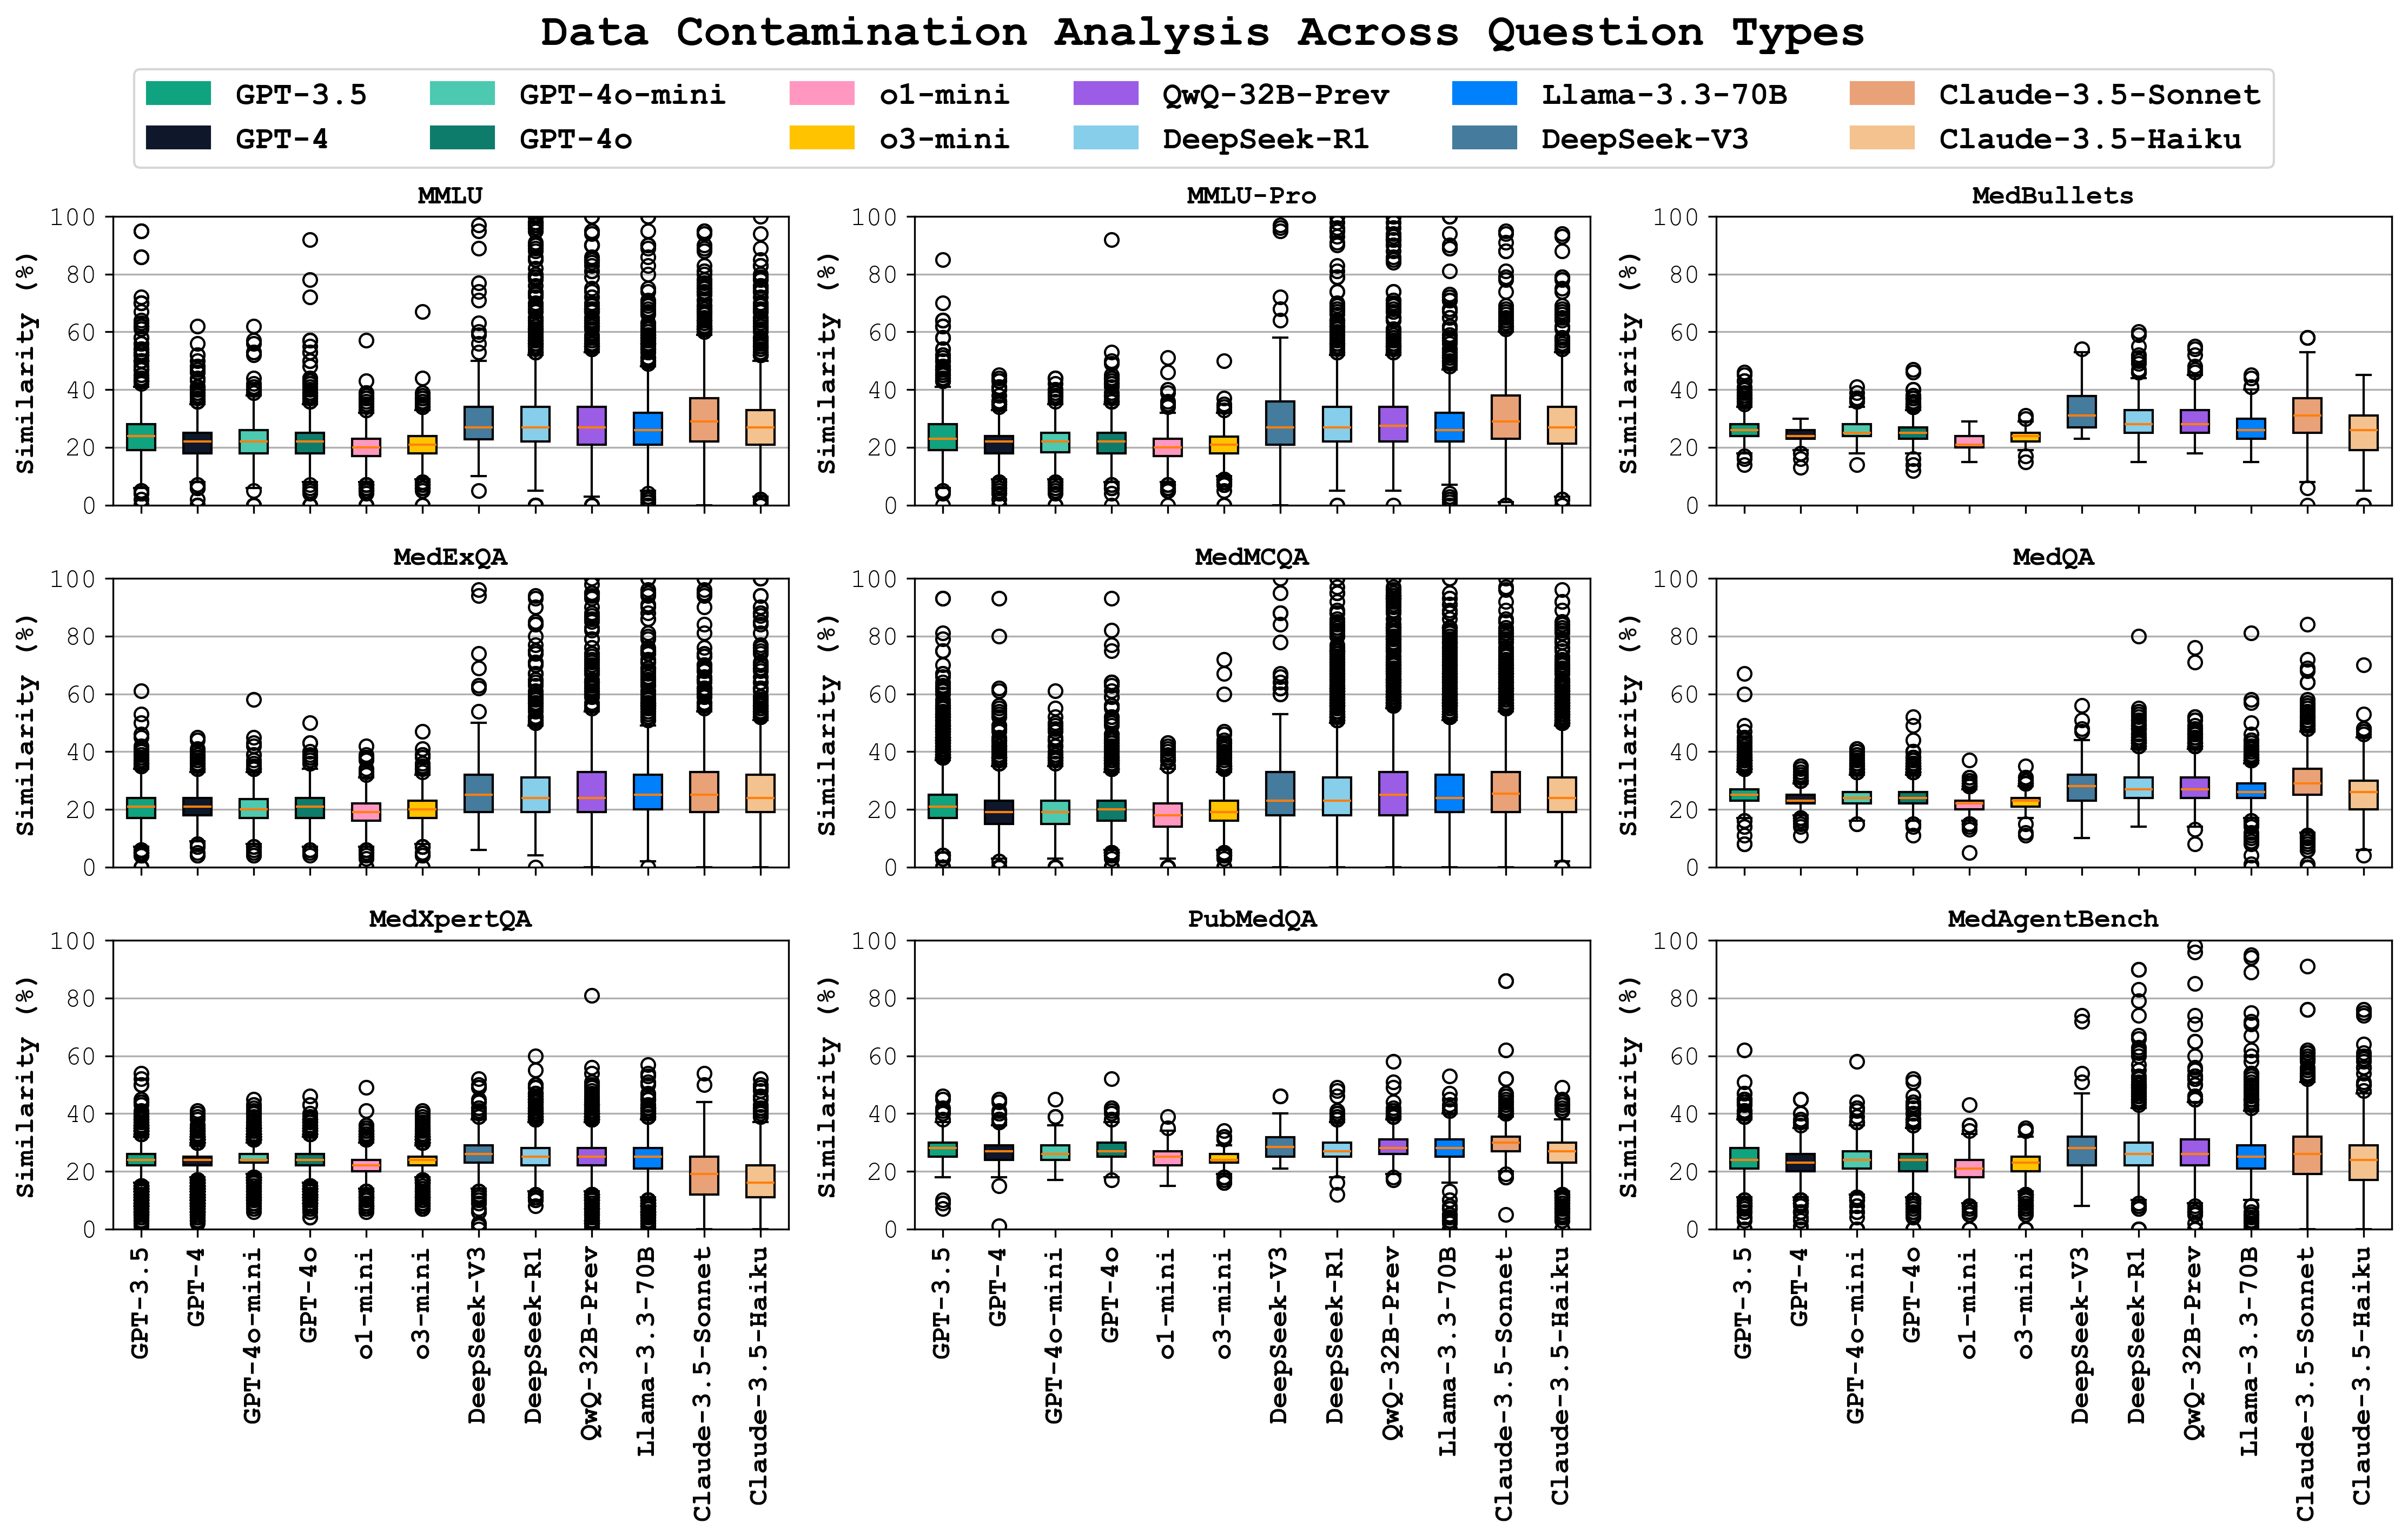

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
from collections import defaultdict
import pandas as pd

# Set style for a clean, modern look
plt.rcParams['font.family'] = 'Courier New'
plt.rcParams['font.size'] = 12

# Custom font settings
title_font = {'family': 'Courier New', 'size': 12, 'weight': 'bold'}
legend_font = {'family': 'Courier New', 'size': 8, 'weight': 'bold'}
number_font = {'family': 'Courier New', 'size': 10}

lev_distances = defaultdict(list)
tasks = {
    'medqa': ['test'],
    'pubmedqa': ['test'],
    'medmcqa': ['test'],
    'medbullets': ['test'],
    'mmlu': ['test'],
    'mmlu-pro': ['test'],
    'medexqa': ['test'],
    'medxpertqa-r': ['test'],
    'medxpertqa-u': ['test'],
    'hard-set': ['test']  # Added hard-set as a task
}
task_map = {
    'medqa': 'MedQA',
    'pubmedqa': 'PubMedQA',
    'medmcqa': 'MedMCQA',
    'medbullets': 'MedBullets',
    'mmlu': 'MMLU',
    'mmlu-pro': 'MMLU-Pro',
    'medexqa': 'MedExQA',
    'medxpertqa-r': 'MedXpertQA',  # Changed to just MedXpertQA
    'medxpertqa-u': 'MedXpertQA',  # Same as above to combine them
    'hard-set': 'MedAgentBench'  # Added mapping for hard-set
}
models = [
    'gpt-35-turbo',
    'gpt-4',
    'gpt-4o-mini',
    'gpt-4o',
    'o1-mini',
    'o3-mini',
    'QwQ-32B-Preview',
    'DeepSeek-R1',
    'Llama-3.3-70B-Instruct-Turbo',
    'DeepSeek-V3',
    'claude-3-5-sonnet',
    'claude-3-5-haiku'
]
model_map = {
    'gpt-35-turbo': 'GPT-3.5',
    'gpt-4': 'GPT-4',
    'gpt-4o-mini': 'GPT-4o-mini',
    'gpt-4o': 'GPT-4o',
    'o1-mini': 'o1-mini',
    'o3-mini': 'o3-mini',
    'DeepSeek-V3': 'DeepSeek-V3',
    'DeepSeek-R1': 'DeepSeek-R1',
    'QwQ-32B-Preview': 'QwQ-32B-Prev',
    'Llama-3.3-70B-Instruct-Turbo': 'Llama-3.3-70B',
    'claude-3-5-sonnet': 'Claude-3.5-Sonnet',
    'claude-3-5-haiku': 'Claude-3.5-Haiku'
}
# Define model colors
base_model_colors = {
    'GPT-3.5': '#10A37F',             # OpenAI teal
    'GPT-4': '#0F172A',               # OpenAI dark slate
    'GPT-4o-mini': '#4CC9B0',         # Light green
    'GPT-4o': '#0E7C6B',              # Deep teal
    'DeepSeek-V3': '#457B9D',         # Rich blue
    'o1-mini': '#FF97C1',             # Strawberry pink
    'o3-mini': '#FFC300',             # Brighter/better yellow
    'QwQ-32B-Prev': '#9B5DE5',             # Royal purple
    'DeepSeek-R1': '#87CEEB',         # Sky blue
    'Llama-3.3-70B': '#0080FB',       # Meta blue
    'Claude-3.5-Sonnet': '#E9A178',   # Deeper peach/terracotta
    'Claude-3.5-Haiku': '#F4C28E'     # Light peach
}

# Collect Levenshtein similarity ratios from JSON files
hard_set = {model: [] for model in models}
for task in tasks:
    if task == 'hard-set':
        continue  # Skip processing hard-set here, we'll handle it separately
    
    for subtask in tasks[task]:
        for model in models:
            try:
                file_path = f'../output/{task}/{model}-{task}-{subtask}-prob.json'
                hard_set_path = f'../data/{task}/test_hard.jsonl'
                hard_set_data = load_jsonl(hard_set_path)
                hard_set_idx = [item['realidx'] for item in hard_set_data]
                data = load_json(file_path)
                hard_set_data = [item for item in data if item['realidx'] in hard_set_idx]
                hard_set[model].extend(hard_set_data)
                for item in data:
                    if 'q2' in item and 'generated_text' in item:
                        distance = item['levenshtein_distance']
                        ratio = int(round((1 - distance / max(len(item['q2']), len(item['generated_text']))) * 100))
                        lev_distances[f"{task}_{model}"].append(ratio)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

# Initialize hard-set data for each model
for model in models:
    lev_distances[f"hard-set_{model}"] = []
    for item in hard_set[model]:
        if 'q2' in item and 'generated_text' in item and 'levenshtein_distance' in item:
            distance = item['levenshtein_distance']
            ratio = int(round((1 - distance / max(len(item['q2']), len(item['generated_text']))) * 100))
            lev_distances[f"hard-set_{model}"].append(ratio)

# Convert the collected data into a DataFrame for improved visualization
data_rows = []
for key, ratios in lev_distances.items():
    if '_' not in key:
        continue
    dataset, model = key.split('_', 1)
    for val in ratios:
        data_rows.append({"Dataset": task_map[dataset], "Model": model_map[model], "Similarity": val})
df = pd.DataFrame(data_rows)

# Create figure and axes grid
# We want exactly 9 plots (3x3 grid)
n_cols = 3
n_rows = 3

# Create the figure with the specified dimensions
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 9), dpi=300)
axes = axes.flatten()

# Get unique datasets, ensuring Hard Set is last
datasets = [d for d in df['Dataset'].unique() if d != 'MedAgentBench']
datasets = sorted(datasets)
if 'MedAgentBench' in df['Dataset'].unique():
    datasets.append('MedAgentBench')

# Create boxplots for each dataset
for idx, dataset in enumerate(datasets[:9]):  # Limit to 9 plots
    dataset_data = df[df['Dataset'] == dataset]
    
    # Create boxplot
    bp = axes[idx].boxplot([dataset_data[dataset_data['Model'] == model]['Similarity'] 
                           for model in model_map.values()],
                          vert=True,
                          patch_artist=True)
    
    # Set colors for boxes
    for box, model in zip(bp['boxes'], model_map.values()):
        box.set(facecolor=base_model_colors[model])
    
    # Customize plot
    axes[idx].set_title(dataset, fontdict=title_font)
    axes[idx].set_ylim(0, 100)
    axes[idx].grid(True, axis='y')
    axes[idx].set_ylabel('Similarity (%)', fontdict=title_font)
    
    # Add x-labels for the last row of plots
    if idx >= 6:  # Last row
        model_labels = list(model_map.values())
        axes[idx].set_xticklabels(model_labels, rotation=90, fontsize=12, fontweight='bold')
    else:
        axes[idx].set_xticklabels([])  # Remove x labels for other rows

# Add a single legend for all subplots
legend_elements = [
    Patch(color=base_model_colors['GPT-3.5'], label='GPT-3.5'),
    Patch(color=base_model_colors['GPT-4'], label='GPT-4'), 
    Patch(color=base_model_colors['GPT-4o-mini'], label='GPT-4o-mini'),
    Patch(color=base_model_colors['GPT-4o'], label='GPT-4o'),
    Patch(color=base_model_colors['o1-mini'], label='o1-mini'),
    Patch(color=base_model_colors['o3-mini'], label='o3-mini'),
    Patch(color=base_model_colors['QwQ-32B-Prev'], label='QwQ-32B-Prev'),
    Patch(color=base_model_colors['DeepSeek-R1'], label='DeepSeek-R1'),
    Patch(color=base_model_colors['Llama-3.3-70B'], label='Llama-3.3-70B'),
    Patch(color=base_model_colors['DeepSeek-V3'], label='DeepSeek-V3'),
    Patch(color=base_model_colors['Claude-3.5-Sonnet'], label='Claude-3.5-Sonnet'),
    Patch(color=base_model_colors['Claude-3.5-Haiku'], label='Claude-3.5-Haiku')
]

fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, 0.98), ncol=6, prop={'size': 14, 'weight': 'bold'})
# Add overall title
fig.suptitle("Data Contamination Analysis Across Question Types", weight='bold', fontsize=20, y=1.05)
# Adjust layout
plt.tight_layout()
plt.savefig('figure3_data_leakage.pdf', bbox_inches='tight')
plt.show()
